## Tweet classification: Trump vs. Trudeau
<p>So you think you can classify text? How about tweets? In this notebook, we'll take a dive into the world of social media text classification by investigating how to properly classify tweets from two prominent North American politicians: Donald Trump and Justin Trudeau.</p>
<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg/800px-President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg" alt="Donald Trump and Justin Trudeau shaking hands." height="50%" width="50%"></p>
<p><a href="https://commons.wikimedia.org/wiki/File:President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference,_February_13,_2017.jpg">Photo Credit: Executive Office of the President of the United States</a></p>
<p>Tweets pose specific problems to NLP, including the fact they are shorter texts. There are also plenty of platform-specific conventions to give you hassles: mentions, #hashtags, emoji, links and short-hand phrases (ikr?). Can we overcome those challenges and build a useful classifier for these two tweeters? Yes! Let's get started.</p>
<p>To begin, we will import all the tools we need  and load our dataset </p>

In [1]:
import random; random.seed(42)
import pandas as pd
import numpy as np
import re, pickle, os
import matplotlib.pyplot as plt

In [2]:
tweet_df = pd.read_csv('tweets.csv')
tweet_df.head()

,id,author,status
0,1,Donald J. Trump,I will be making a major statement from the @W...
1,2,Donald J. Trump,Just arrived at #ASEAN50 in the Philippines fo...
2,3,Donald J. Trump,"After my tour of Asia, all Countries dealing w..."
3,4,Donald J. Trump,Great to see @RandPaul looking well and back o...
4,5,Donald J. Trump,Excited to be heading home to see the House pa...


In [3]:
tr_tweet_df = tweet_df[tweet_df['author'] == 'Donald J. Trump']
tr_tweet_df.head()

,id,author,status
0,1,Donald J. Trump,I will be making a major statement from the @W...
1,2,Donald J. Trump,Just arrived at #ASEAN50 in the Philippines fo...
2,3,Donald J. Trump,"After my tour of Asia, all Countries dealing w..."
3,4,Donald J. Trump,Great to see @RandPaul looking well and back o...
4,5,Donald J. Trump,Excited to be heading home to see the House pa...


In [4]:
tr_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      200 non-null    int64 
 1   author  200 non-null    object
 2   status  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.2+ KB


# cleaning data and processing 
<p> get the tweet and tokinze and lower it and remove non assici words and all ( English + French ) stop words , remove urls  </p>
<p> apply all of above steps to our data then using ngrams to get the common words each person talk about  </p> 

In [5]:
import nltk
from nltk.corpus import stopwords, wordnet 
from nltk.stem import WordNetLemmatizer
def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
additional_stop_words=['twitter','com','pic','via']
def clean_text (text):
  text_clean = text.lower()
  text_clean =  re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean) 
  text_clean = re.sub(r'http\S+', ' ', text_clean).split()  
  text_clean = [w for w in text_clean if len(w) > 2]
  lemmatizer = WordNetLemmatizer()
  text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean ]
  stops = set(stopwords.words('english')+stopwords.words('french')).union(additional_stop_words)
  text_clean = [w for w in text_clean if w not in stops]
  return text_clean

tr_tweet_df['token'] = [clean_text(x) for x in tr_tweet_df['status']] 
tr_tweet_df.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,author,status,token
0,1,Donald J. Trump,I will be making a major statement from the @W...,"[make, major, statement, whitehouse, upon, ret..."
1,2,Donald J. Trump,Just arrived at #ASEAN50 in the Philippines fo...,"[arrive, asean, philippine, final, stop, world..."
2,3,Donald J. Trump,"After my tour of Asia, all Countries dealing w...","[tour, asia, country, deal, trade, know, rule,..."
3,4,Donald J. Trump,Great to see @RandPaul looking well and back o...,"[great, see, randpaul, look, well, back, senat..."
4,5,Donald J. Trump,Excited to be heading home to see the House pa...,"[excite, head, home, see, house, great, tax, b..."


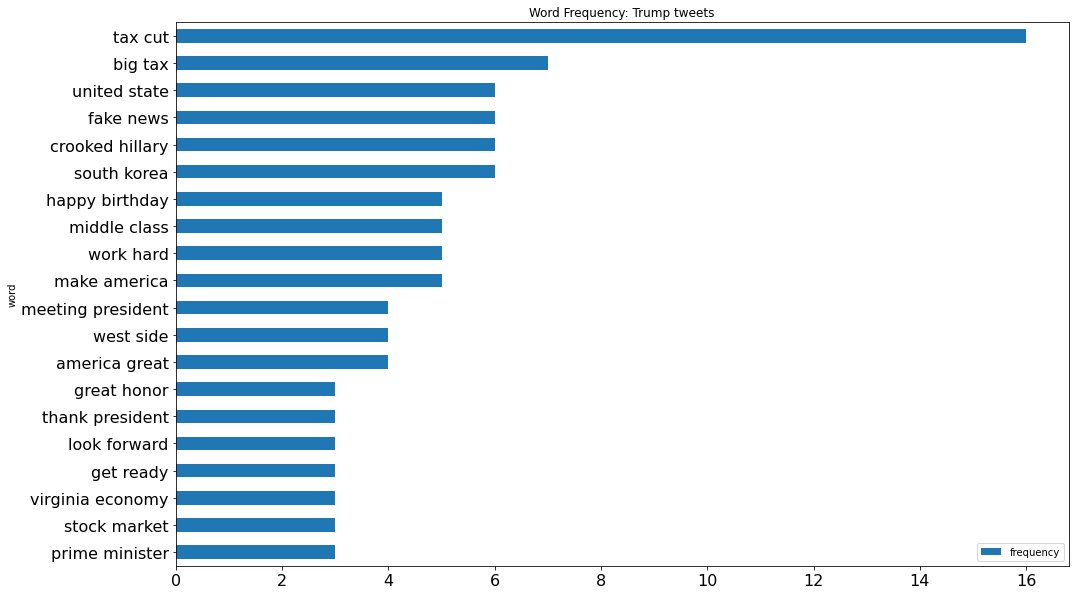

In [7]:
from nltk.util import ngrams
from collections import Counter
All_text = [ w for tweet in tr_tweet_df['token'] for w in tweet]
bigrams = list(ngrams(All_text , 2))
common_bigrams = Counter(bigrams).most_common()
words_count = pd.DataFrame(data = common_bigrams , columns=['word','frequency'])
words_count['word'] = words_count['word'].apply(' '.join)
title = "Word Frequency: Trump tweets"
words_count.head(20).sort_values('frequency').plot.barh(x='word', y='frequency', title=title,figsize=(16,10), fontsize=16)


(-0.5, 1599.5, 1199.5, -0.5)

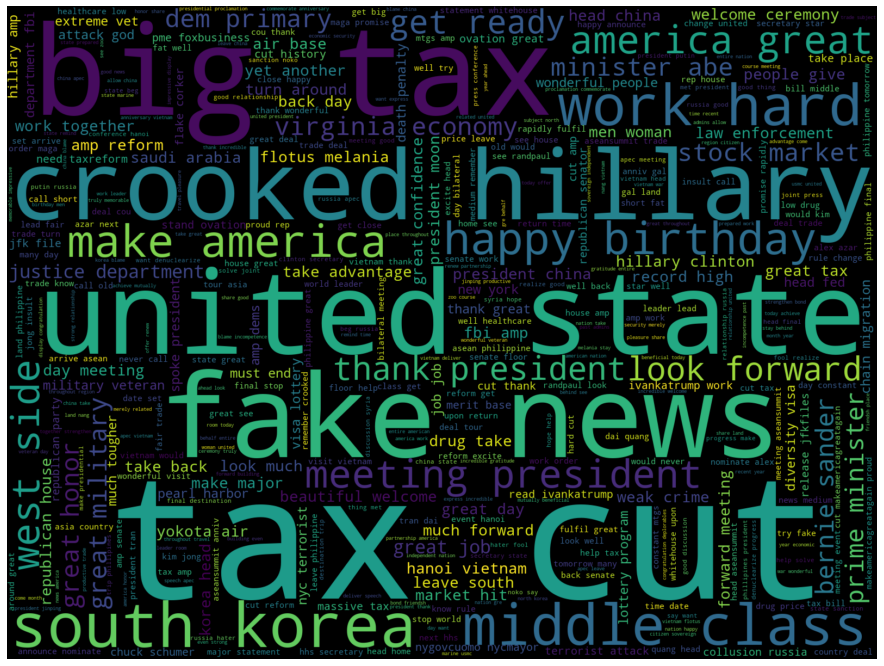

In [8]:
from wordcloud import WordCloud

word_count_dict = {}
for w, f in words_count.values:
    word_count_dict[w] = f

wordcloud = WordCloud(max_words=400, width=1600, height=1200, random_state=42)

wordcloud.generate_from_frequencies(word_count_dict)    
plt.figure(figsize=(16,12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [9]:
tweet_df.tail()

,id,author,status
395,396,Justin Trudeau,RT @googlecanada: Watch tmw: @JustinTrudeau di...
396,397,Justin Trudeau,"Today in Ottawa, I met with the Modern Treaty ..."
397,398,Justin Trudeau,Voici le sommaire de ma rencontre avec les Pre...
398,399,Justin Trudeau,RT @VeteransENG_CA: #Day1 of 11 Days of Rememb...
399,400,Justin Trudeau,RT @VeteransFR_CA: #Jour1 des 11 jours pour se...


In [10]:
ju_tweet_df = tweet_df[tweet_df['author'] == 'Justin Trudeau']
ju_tweet_df.head()

,id,author,status
200,201,Justin Trudeau,RT @NavdeepSBains: Innovation at work! Canadia...
201,202,Justin Trudeau,RT @NavdeepSBains: L'innovation en action ! Le...
202,203,Justin Trudeau,I'll always be grateful for George Gosbee's wo...
203,204,Justin Trudeau,Je serai toujours reconnaissant pour le travai...
204,205,Justin Trudeau,RT @FP_Champagne: All fired up with the larges...


In [11]:
ju_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 200 to 399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      200 non-null    int64 
 1   author  200 non-null    object
 2   status  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.2+ KB


In [12]:
ju_tweet_df['token'] = [clean_text(x) for x in ju_tweet_df['status']] 
ju_tweet_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,author,status,token
200,201,Justin Trudeau,RT @NavdeepSBains: Innovation at work! Canadia...,"[navdeepsbains, innovation, work, canadian, in..."
201,202,Justin Trudeau,RT @NavdeepSBains: L'innovation en action ! Le...,"[navdeepsbains, innovation, action, entreprise..."
202,203,Justin Trudeau,I'll always be grateful for George Gosbee's wo...,"[always, grateful, george, gosbee, work, advis..."
203,204,Justin Trudeau,Je serai toujours reconnaissant pour le travai...,"[toujours, reconnaissant, travail, george, gos..."
204,205,Justin Trudeau,RT @FP_Champagne: All fired up with the larges...,"[champagne, fire, large, business, delegation,..."


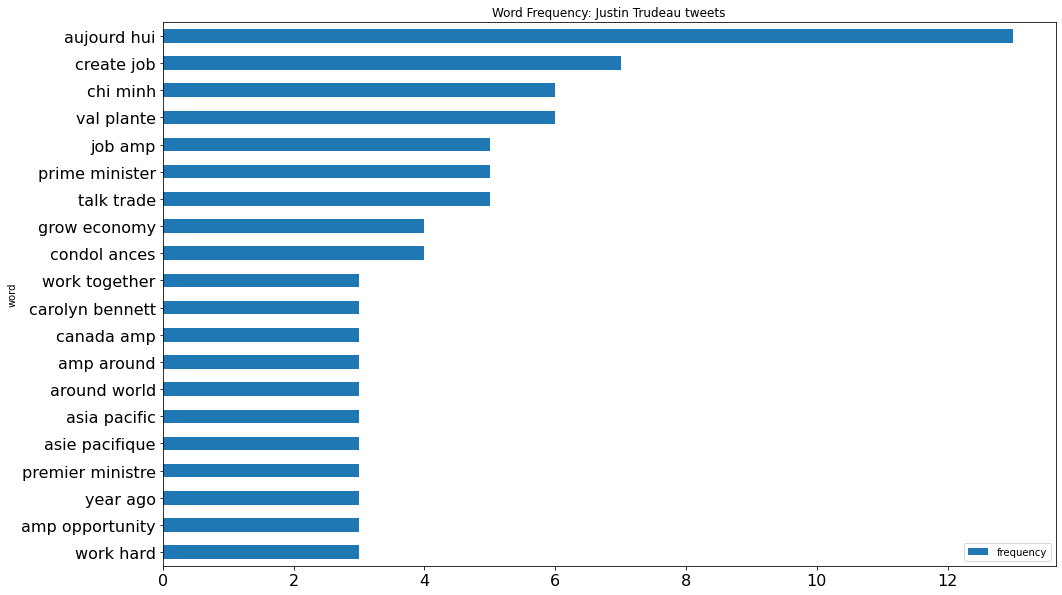

In [13]:
ju_All_text = [ w for tweet in ju_tweet_df['token'] for w in tweet]
ju_bigrams = list(ngrams(ju_All_text , 2))
ju_common_bigrams = Counter(ju_bigrams).most_common()
ju_words_count = pd.DataFrame(data = ju_common_bigrams , columns=['word','frequency'])
ju_words_count['word'] = ju_words_count['word'].apply(' '.join)
title = "Word Frequency: Justin Trudeau tweets"
ju_words_count.head(20).sort_values('frequency').plot.barh(x='word', y='frequency', title=title,figsize=(16,10), fontsize=16)


(-0.5, 1599.5, 1199.5, -0.5)

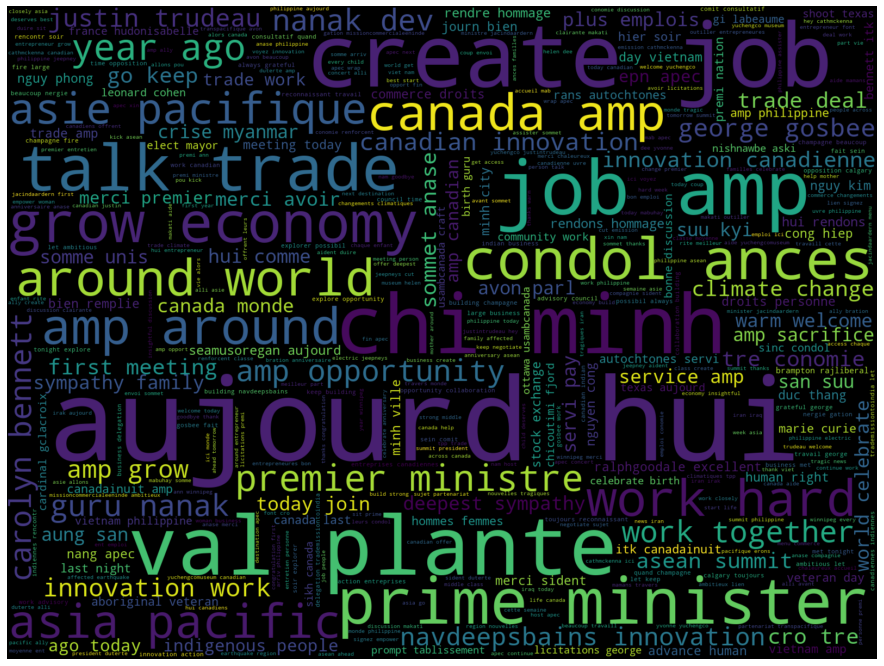

In [14]:
ju_word_count_dict = {}
for w, f in ju_words_count.values:
    ju_word_count_dict[w] = f

ju_wordcloud = WordCloud(max_words=400, width=1600, height=1200, random_state=42)

ju_wordcloud.generate_from_frequencies(ju_word_count_dict)    
plt.figure(figsize=(16,12)) 
plt.imshow(ju_wordcloud, interpolation="bilinear")
plt.axis("off")

## Now will bulid model to clssify text to know who's write this twet 
<p>To begin, we will import all the tools we need from scikit-learn. We will need to properly vectorize our data (<code>CountVectorizer</code> and <code>TfidfVectorizer</code>). And we will also want to import some models, including <code>MultinomialNB</code> from the <code>naive_bayes</code> module, <code>LinearSVC</code> from the <code>svm</code> module and <code>PassiveAggressiveClassifier</code> from the <code>linear_model</code> module. Finally, we'll need <code>sklearn.metrics</code> and <code>train_test_split</code> and <code>GridSearchCV</code> from the <code>model_selection</code> module to evaluate and optimize our model.</p>

In [15]:
# Import all we need from sklearn
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

In [16]:
import pandas as pd

# Load data
tweet_df = pd.read_csv('tweets.csv')
tweet_df.head()

,id,author,status
0,1,Donald J. Trump,I will be making a major statement from the @W...
1,2,Donald J. Trump,Just arrived at #ASEAN50 in the Philippines fo...
2,3,Donald J. Trump,"After my tour of Asia, all Countries dealing w..."
3,4,Donald J. Trump,Great to see @RandPaul looking well and back o...
4,5,Donald J. Trump,Excited to be heading home to see the House pa...


## Transforming our collected data
<p>To begin, let's start with a corpus of tweets which were collected in November 2017. They are available in CSV format. We'll use a Pandas DataFrame to help import the data and pass it to cleantext function for further processing.</p>
<p>Since the data has been collected via the Twitter API and not split into test and training sets, we'll need to do this. Let's use <code>train_test_split()</code> with <code>random_state=53</code> and a test size of 0.33, just as we did in the DataCamp course. This will ensure we have enough test data and we'll get the same results no matter where or when we run this code.</p>

In [17]:
tweet_df['token'] = [clean_text(x) for x in tweet_df['status']]
tweet_df['token'] = [' '.join(tweet) for tweet in tweet_df['token'] ]
tweet_df.head()

,id,author,status,token
0,1,Donald J. Trump,I will be making a major statement from the @W...,make major statement whitehouse upon return ti...
1,2,Donald J. Trump,Just arrived at #ASEAN50 in the Philippines fo...,arrive asean philippine final stop world leade...
2,3,Donald J. Trump,"After my tour of Asia, all Countries dealing w...",tour asia country deal trade know rule change ...
3,4,Donald J. Trump,Great to see @RandPaul looking well and back o...,great see randpaul look well back senate floor...
4,5,Donald J. Trump,Excited to be heading home to see the House pa...,excite head home see house great tax bill midd...


In [18]:
# Create target
y = tweet_df['author']
x =  tweet_df['token']
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.33,
                                                    random_state=53)

## 3. Vectorize the tweets
<p>We have the training and testing data all set up, but we need to create vectorized representations of the tweets in order to apply machine learning.</p>
<p>To do so, we will utilize the <code>CountVectorizer</code> and <code>TfidfVectorizer</code> classes which we will first need to fit to the data.</p>
<p>Once this is complete, we can start modeling with the new vectorized tweets!</p>

In [19]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english',
                                   max_df =0.9 , min_df =0.05)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [20]:
# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   max_df =0.9 , min_df =0.05)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training a multinomial naive Bayes model
<p>Now that we have the data in vectorized form, we can train the first model. Investigate using the Multinomial Naive Bayes model with both the <code>CountVectorizer</code> and <code>TfidfVectorizer</code> data. Which do will perform better? How come?</p>
<p>To assess the accuracies, we will print the test sets accuracy scores for both models.</p>

In [21]:
# Create a MulitnomialNB model
tfidf_nb = MultinomialNB()

# ... Train your model here ...
tfidf_nb.fit(tfidf_train,y_train)
# Run predict on your TF-IDF test data to get your predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of your predictions
tfidf_nb_score = metrics.accuracy_score(y_test , tfidf_nb_pred)

In [22]:
# Create a MulitnomialNB model
count_nb = MultinomialNB()
# ... Train your model here ...
count_nb.fit(count_train,y_train)
# Run predict on your count test data to get your predictions
count_nb_pred = count_nb.predict(count_test)

# Calculate the accuracy of your predictions
count_nb_score =  metrics.accuracy_score(y_test , count_nb_pred)

In [23]:
print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.6136363636363636
NaiveBayes Count Score:  0.6136363636363636


##  Evaluating our model using a confusion matrix
<p>We see that the TF-IDF model performs better than the count-based approach. Based on what we know from the NLP fundamentals course, why might that be? We know that TF-IDF allows unique tokens to have a greater weight - perhaps tweeters are using specific important words that identify them! Let's continue the investigation.</p>
<p>For classification tasks, an accuracy score doesn't tell the whole picture. A better evaluation can be made if we look at the confusion matrix, which shows the number correct and incorrect classifications based on each class. We can use the metrics, True Positives, False Positives, False Negatives, and True Negatives, to determine how well the model performed on a given class. How many times was Trump misclassified as Trudeau?</p>

Confusion matrix, without normalization
Confusion matrix, without normalization


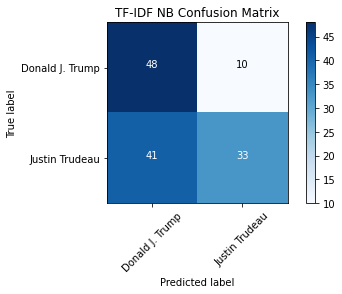

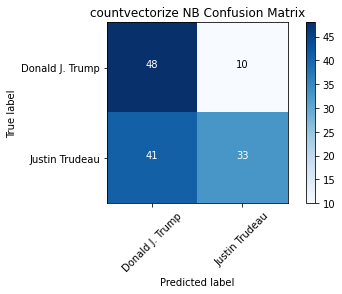

In [24]:
%matplotlib inline

from helper_functions import plot_confusion_matrix

# Calculate the confusion matrices for the tfidf_nb model and count_nb models
tfidf_nb_cm = metrics.confusion_matrix(y_test,tfidf_nb_pred)
count_nb_cm = metrics.confusion_matrix(y_test,count_nb_pred)

# Plot the tfidf_nb_cm confusion matrix
plot_confusion_matrix(tfidf_nb_cm, classes=['Donald J. Trump', 'Justin Trudeau']
                      , title="TF-IDF NB Confusion Matrix")

# Plot the count_nb_cm confusion matrix without overwriting the first plot 
plot_confusion_matrix(count_nb_cm, classes=['Donald J. Trump', 'Justin Trudeau']
                      , title="countvectorize NB Confusion Matrix", figure=1)

## Trying out another classifier: Linear SVC
<p>So the Bayesian model only has one prediction difference between the TF-IDF and count vectorizers -- fairly impressive! Interestingly, there is some confusion when the predicted label is Trump but the actual tweeter is Trudeau. If we were going to use this model, we would want to investigate what tokens are causing the confusion in order to improve the model. </p>
<p>Now that we've seen what the Bayesian model can do, how about trying a different approach? <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">LinearSVC</a> is another popular choice for text classification. Let's see if using it with the TF-IDF vectors improves the accuracy of the classifier!</p>

LinearSVC Score:   0.667
Confusion matrix, without normalization


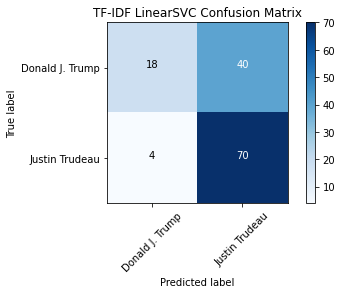

In [25]:
# Create a LinearSVM model
tfidf_svc = LinearSVC()

# ... Train your model here ...
tfidf_svc.fit(tfidf_train,y_train)
# Run predict on your tfidf test data to get your predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate your accuracy using the metrics module
tfidf_svc_score = metrics.accuracy_score(tfidf_svc_pred,y_test)

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Calculate the confusion matrices for the tfidf_svc model
svc_cm =  metrics.confusion_matrix(y_test,tfidf_svc_pred)

# Plot the confusion matrix using the plot_confusion_matrix function
plot_confusion_matrix(svc_cm, classes=['Donald J. Trump', 'Justin Trudeau']
                      , title="TF-IDF LinearSVC Confusion Matrix")

## Introspecting our top model
<p>Wow, the LinearSVC model is even better than the Multinomial Bayesian one. Nice work! Via the confusion matrix we can see that, although there is still some confusion where Trudeau's tweets are classified as Trump's, the False Positive rate is better than the previous model. So, we have a performant model, right? </p>
<p>We might be able to continue tweaking and improving all of the previous models by learning more about parameter optimization or applying some better preprocessing of the tweets. </p>
<p>Now let's see what the model has learned. Using the LinearSVC Classifier with two classes (Trump and Trudeau) we can sort the features (tokens), by their weight and see the most important tokens for both Trump and Trudeau. What are the most Trump-like or Trudeau-like words? Did the model learn something useful to distinguish between these two men? </p>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


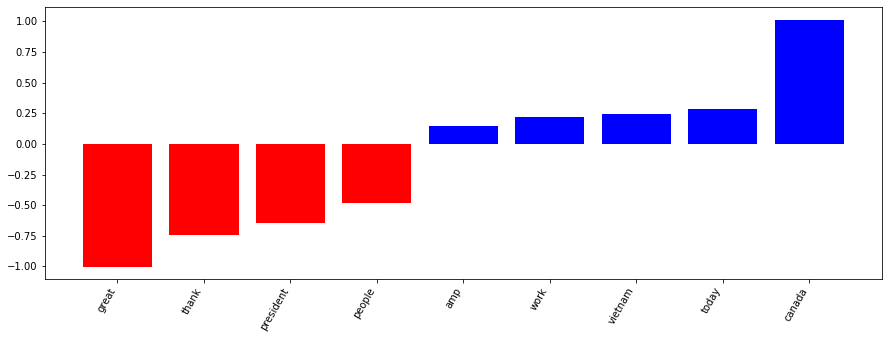

[(-1.001577352615148, 'great'),
 (-0.7424366486940474, 'thank'),
 (-0.6421733840805689, 'president'),
 (-0.48035455790471493, 'people'),
 (0.14850532433110106, 'amp'),
 (0.22153635291128512, 'work'),
 (0.24474709838184916, 'vietnam'),
 (0.28361932309194177, 'today'),
 (1.014558950235974, 'canada')]


In [26]:
from helper_functions import plot_and_return_top_features

# Import pprint from pprint
from pprint import pprint

# Get the top features using the plot_and_return_top_features function and your top model and tfidf vectorizer
top_features = plot_and_return_top_features(tfidf_svc, tfidf_vectorizer)

# pprint the top features
pprint(top_features)

<p> write your own tweet using the knowledge gained to trick the model! Use the printed list or plot above to make some inferences about what words will classify your text as Trump or Trudeau. Can you fool the model into thinking you are Trump or Trudeau?</p>

In [27]:
# Write two tweets as strings, one which you want to classify as Trump and one as Trudeau
trump_tweet = 'I will be making a major statement'
trudeau_tweet = 'Canada les'

# Vectorize each tweet using the TF-IDF vectorizer's transform method
# Note: `transform` needs the string in a list object (i.e. [trump_tweet])
trump_tweet_vectorized = tfidf_vectorizer.transform([trump_tweet])
trudeau_tweet_vectorized = tfidf_vectorizer.transform([trudeau_tweet])

# Call the predict method on your vectorized tweets
trump_tweet_pred = tfidf_svc.predict(trump_tweet_vectorized)
trudeau_tweet_pred = tfidf_svc.predict(trudeau_tweet_vectorized)

print("Predicted Trump tweet", trump_tweet_pred)
print("Predicted Trudeau tweet", trudeau_tweet_pred)

Predicted Trump tweet ['Justin Trudeau']
Predicted Trudeau tweet ['Justin Trudeau']


### Use GridSearchCV to improve both your Bayesian and LinearSVC models by finding the optimal parameters

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf_vectorize', TfidfVectorizer()), ('classifer', MultinomialNB)])
grid_search = [{'classifer':[ MultinomialNB()]},
               {'classifer':[ LinearSVC()]}
               ]
clf = GridSearchCV(estimator=pipe , param_grid= grid_search , cv =10)
best_model = clf.fit(X_train ,y_train)
print('best score %f with model %s' % (best_model.best_score_ , best_model.best_params_ ))


best score 0.936467 with model {'classifer': LinearSVC()}


Best Bodel Score:   0.932
Confusion matrix, without normalization


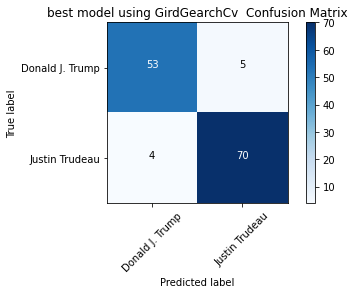

In [29]:
best_model_pred = best_model.predict(X_test)

# Calculate your accuracy using the metrics module
best_model_score = metrics.accuracy_score(best_model_pred,y_test)

print("Best Bodel Score:   %0.3f" % best_model_score)

# Calculate the confusion matrices for the tfidf_svc model
best_model_cm =  metrics.confusion_matrix(y_test,best_model_pred)

# Plot the confusion matrix using the plot_confusion_matrix function
plot_confusion_matrix(best_model_cm, classes=['Donald J. Trump', 'Justin Trudeau']
                      , title="best model using GirdGearchCv  Confusion Matrix")